#### Notebook 'Tempo_sin_PCA_CORRUPCIÓN'

In [53]:
# Carga de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from itertools import combinations
from collections import Counter
from pyvis.network import Network
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



In [54]:
# Crear el DataFrame 'df_aspectos' con los aspectos y las variables asociadas
data_aspectos = {
    'aspecto': ['CORRUPCIÓN'],
    'var_1': ['per304'],
    'var_2': ['per603'],
    'var_3': ['per604'],
    'var_4': ['per605']
}
df_aspectos = pd.DataFrame(data_aspectos)
display(df_aspectos)
# cargar Analytical_Data
df_AD = pd.read_excel('data/Analytical_Data.xlsx')
display(df_AD.head())

,aspecto,var_1,var_2,var_3,var_4
0,CORRUPCIÓN,per304,per603,per604,per605


,Dominio,Nombre_Dominio,Variable_per,Detalle_Dominio
0,Domain_1,External Relations,per101,Foreign Special Relationships: Positive
1,Domain_1,External Relations,per102,Foreign Special Relationships: Negative
2,Domain_1,External Relations,per103,Anti-Imperialism
3,Domain_1,External Relations,per104,Military: Positive
4,Domain_1,External Relations,per105,Military: Negative


In [55]:
df_AD.columns

Index(['Dominio', 'Nombre_Dominio', 'Variable_per', 'Detalle_Dominio'], dtype='object')

In [56]:
# Cargar datasets
df = pd.read_excel('./data/MP_ponderado_y_normalizado.xlsx')  # Dataset principal
print("Datos cargados:")
display(df.head())


Datos cargados:


,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per605,per606,per607,per608,per701,per702,per703,per704,per705,per706
0,1997,Albania,2.047208,0.000000,0.036283,3.521667,0.018391,0.037353,3.937380,1.288893,...,7.132017,0.801174,0.054652,0.0,0.755637,0.000000,8.333838,0.00000,0.500146,4.364612
1,2001,Albania,2.761724,0.000000,0.000000,3.182847,0.030726,0.027643,4.066757,1.676930,...,5.769535,0.645332,0.010242,0.0,0.255287,0.000000,13.905792,0.00000,0.626465,6.249323
2,1989,Argentina,0.000000,0.000000,4.643342,0.450962,0.832361,0.339836,2.970526,0.000000,...,1.456814,7.635007,0.328238,0.0,6.831962,0.000000,2.508315,0.00000,0.205098,2.063148
3,1995,Argentina,0.062411,0.020391,0.145034,0.893437,0.084040,1.121093,2.020915,1.690770,...,0.770212,2.022833,0.328013,0.0,2.962340,0.000000,1.517723,0.00000,0.250178,1.217375
4,1999,Argentina,0.198715,0.000000,0.601030,0.541209,0.018401,0.633114,3.594509,2.334666,...,4.473842,2.576219,0.958226,0.0,2.616696,0.092213,1.109202,0.04071,0.928451,1.506127


In [57]:
df.columns

Index(['agno', 'countryname', 'per101', 'per102', 'per103', 'per104', 'per105',
       'per106', 'per107', 'per108', 'per109', 'per110', 'per201', 'per202',
       'per203', 'per204', 'per301', 'per302', 'per303', 'per304', 'per305',
       'per401', 'per402', 'per403', 'per404', 'per405', 'per406', 'per407',
       'per408', 'per409', 'per410', 'per411', 'per412', 'per413', 'per414',
       'per415', 'per416', 'per501', 'per502', 'per503', 'per504', 'per505',
       'per506', 'per507', 'per601', 'per602', 'per603', 'per604', 'per605',
       'per606', 'per607', 'per608', 'per701', 'per702', 'per703', 'per704',
       'per705', 'per706'],
      dtype='object')

In [58]:
df.shape

(739, 58)

#### Paso 3: Funciones en pipeline de proceso

##### Filtrar y Normalizar

In [59]:
def preprocesar_periodo(df, desde, hasta):
    """
    Preprocesa el DataFrame para el período seleccionado.
    Combina registros de países con múltiples elecciones en el período y normaliza las variables.
    
    Parámetros:
    - df: DataFrame principal con datos de programas de gobierno.
    - desde: Año inicial del período.
    - hasta: Año final del período.

    Retorna:
    - df_periodo: DataFrame preprocesado con un registro por país en el período.
    """
    # Filtrar el DataFrame para el período
    df_periodo = df[(df['agno'] >= desde) & (df['agno'] <= hasta)]

    # Identificar países con más de una elección en el período
    duplicated_countries = df_periodo['countryname'].value_counts()
    duplicated_countries = duplicated_countries[duplicated_countries > 1]

    if not duplicated_countries.empty:
        #print("\nPaíses con más de una elección en el período:")
        for country in duplicated_countries.index:
            #print(f"\n{country}:")

            # Filtrar datos del país con duplicados
            country_data = df_periodo[df_periodo['countryname'] == country]

            # Imprimir los registros originales
            #print(f"Registros originales ({len(country_data)}):")
            #display(country_data)

            # Promediar las columnas `per` y conservar el primer año
            per_columns = [col for col in df_periodo.columns if col.startswith('per')]
            averaged_row = country_data[per_columns].mean().to_dict()
            averaged_row['agno'] = country_data['agno'].min()  # Primer año del período
            averaged_row['countryname'] = country

            # Imprimir los valores promedio
            #print("\nValores promediados:")
            # for key, value in averaged_row.items():
            #     if key in per_columns:  # Solo mostrar columnas 'per'
            #         print(f"{key}: {value:.4f}")

            # Eliminar los registros originales del dataframe filtrado
            df_periodo = df_periodo[df_periodo['countryname'] != country]

            # Agregar el registro promediado al dataframe
            df_periodo = pd.concat([df_periodo, pd.DataFrame([averaged_row])], ignore_index=True)

    else:
        print("\nNo hay países con más de una elección en el período.")

    # Verificar los resultados finales
    #print("\nDataframe ajustado (un registro por país en el período):")
    #display(df_periodo)

    return df_periodo


##### K-MEANS

In [60]:
def ejecutar_y_visualizar_kmeans(df_filtered, variables, aspecto_filtro, desde, hasta, registros_codo):
    """
    Ejecuta K-MEANS, calcula el K óptimo usando el método del codo, aplica K-MEANS con 3 clústeres,
    y visualiza los resultados. Registra el óptimo de clústeres para cada período.

    Parámetros:
    - df_filtered: DataFrame filtrado y normalizado.
    - variables: Lista de variables 'per' a incluir en el análisis.
    - aspecto_filtro: Aspecto analizado (str).
    - desde: Año inicial del período.
    - hasta: Año final del período.
    - registros_codo: DataFrame para registrar el K óptimo por período.

    Retorna:
    - kmeans: Objeto K-MEANS ajustado.
    """

    # Paso 1: Extraer las variables numéricas
    X = df_filtered[variables]
    
    # Validar si hay suficientes muestras
    n_samples = X.shape[0]
    if n_samples < 3:  # Al menos 3 muestras para K-MEANS con 3 clústeres
        print(f"Período {desde}-{hasta}: No hay suficientes datos para clustering. Muestras: {n_samples}")
        registros_codo.append({'Periodo': f"{desde}-{hasta}", 'K_Optimo': None})
        return None

    # Paso 2: Método del codo para determinar el número óptimo de clústeres
    wcss = []  # Suma de los cuadrados dentro del cluster
    K = range(1, min(11, n_samples + 1))  # Asegurar que K no exceda el número de muestras

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    # Calcular el k óptimo usando la mayor caída relativa
    diffs = np.diff(wcss)
    k_optimo = np.argmin(diffs) + 2  # +2 porque el índice empieza en 0

    # Registrar el k óptimo para el período
    registros_codo.append({'Periodo': f"{desde}-{hasta}", 'K_Optimo': k_optimo})

    # Imprimir el k óptimo
    # print(f"K óptimo calculado mediante el método del codo: {k_optimo}")

    # # Visualizar el método del codo
    # plt.figure(figsize=(8, 5))
    # plt.plot(K, wcss, 'bx-', label="WCSS")
    # plt.axvline(x=k_optimo, color='red', linestyle='--', label=f"K óptimo = {k_optimo}")
    # plt.xlabel('Número de clusters (K)')
    # plt.ylabel('Suma de los cuadrados dentro del cluster (WCSS)')
    # plt.title(f'Método del codo para K óptimo\nAspecto: {aspecto_filtro} | Período: {desde}-{hasta}')
    # plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
    # plt.legend()
    # plt.tight_layout()
    # plt.show()

    # Paso 3: Aplicar K-MEANS con 3 clústeres (o menos si hay pocas muestras)
    optimal_k = min(3, n_samples)  # Ajustar el número de clústeres si hay pocas muestras
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    df_filtered['Cluster'] = kmeans.fit_predict(X)

    # Paso 4: Imprimir los países en cada clúster
    for cluster in range(optimal_k):
        paises_cluster = df_filtered[df_filtered['Cluster'] == cluster]['countryname'].tolist()
        print(f"Cluster {cluster}: {', '.join(paises_cluster)}")

    return kmeans


##### Matriz de coincidencias

In [61]:
def construir_matriz_coincidencias(resultados_temporales):
    coincidencias = Counter()
    for clusters in resultados_temporales.values():
        for cluster in clusters.values():
            for pair in combinations(sorted(cluster), 2):
                coincidencias[pair] += 1

    # Convertir a matriz
    paises = sorted(set([p for pair in coincidencias.keys() for p in pair]))
    coincidence_matrix = pd.DataFrame(0, index=paises, columns=paises)

    for (p1, p2), count in coincidencias.items():
        coincidence_matrix.loc[p1, p2] = count
        coincidence_matrix.loc[p2, p1] = count

    return coincidence_matrix


#### Grafo de Trayectorias temporales

#### Gráfico de coincidencias (con un cierto mínimo)

In [62]:
# LOUVAIN
from pyvis.network import Network
import networkx as nx
from community import community_louvain  # Librería para Louvain

def grafo_coincidencias_filtrado(coincidence_matrix, min_coincidencias=10):
    """
    Crea un grafo interactivo mejorado a partir de la matriz de coincidencias,
    filtrando conexiones con menos de `min_coincidencias` coincidencias.
    
    Parámetros:
    - coincidence_matrix: Matriz de coincidencias entre países.
    - min_coincidencias: Número mínimo de coincidencias para mostrar una conexión.
    """
    # Crear el grafo de NetworkX
    G = nx.Graph()
    for i, row in coincidence_matrix.iterrows():
        for j, value in row.items():
            if value >= min_coincidencias:  # Filtrar por número mínimo de coincidencias
                G.add_edge(i, j, weight=value)  # Añadir peso correctamente

    # Detectar comunidades usando el algoritmo Louvain
    partition = community_louvain.best_partition(G)
    communities = {}
    for node, community in partition.items():
        communities.setdefault(community, []).append(node)

    # Crear un grafo interactivo con PyVis
    net = Network(notebook=True, height="750px", width="100%", cdn_resources="remote")
    net.from_nx(G)

    # Configurar físicas para deshabilitarlas
    net.set_options("""
    var options = {
      "physics": {
        "enabled": false
      }
    }
    """)

    # Ajustar nodos y aristas
    for node in net.nodes:
        # Color del nodo según la comunidad detectada
        community = partition[node["id"]]
        node["color"] = f"hsl({community * 360 / len(communities)}, 70%, 70%)"
        
        # Tamaño del nodo según el grado
        node["value"] = len(list(G.neighbors(node["id"])))

    for edge in net.edges:
        # Grosor de las aristas según el peso
        from_node = edge["from"]
        to_node = edge["to"]
        if G.has_edge(from_node, to_node):
            edge["width"] = G[from_node][to_node].get("weight", 1)  # Usar 1 como valor por defecto

    # Calcular métricas de centralidad
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)

    # Mostrar las métricas en la terminal
    print("\nCentralidad de Grado (Top 5):")
    for node, centrality in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"{node}: {centrality:.4f}")

    print("\nCentralidad de Betweenness (Top 5):")
    for node, centrality in sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"{node}: {centrality:.4f}")

    # Guardar el grafo en un archivo HTML
    output_file = "LOUVAIN_grafo_coincidencias_filtrado.html"
    net.show(output_file)
    print(f"Grafo guardado como '{output_file}'. Ábrelo para visualizar.")


#### Heatmap de coincidencias (con un cierto mínimo)

In [63]:
def heatmap_coincidencias_filtrado(coincidence_matrix, min_coincidencias=10, cmap="coolwarm"):
    """
    Genera un heatmap mostrando solo los países que tienen coincidencias >= min_coincidencias,
    con las celdas que cumplen mostrando el número real de coincidencias y las que no cumplen en blanco.
    
    Parámetros:
    - coincidence_matrix: Matriz de coincidencias entre países.
    - min_coincidencias: Número mínimo de coincidencias para considerar un enlace.
    - cmap: Paleta de colores para el heatmap.
    """
    # Crear una copia de la matriz para no modificar el original
    filtered_matrix = coincidence_matrix.copy()
    
    # Filtrar países que cumplen el umbral en filas o columnas
    relevant_countries = (filtered_matrix >= min_coincidencias).sum(axis=1) > 0
    filtered_matrix = filtered_matrix.loc[relevant_countries, relevant_countries]
    
    # Crear una máscara para ocultar valores por debajo del umbral
    mask = filtered_matrix < min_coincidencias
    
    # Verificar si quedan datos para graficar
    if filtered_matrix.empty:
        print(f"No hay países con coincidencias >= {min_coincidencias}.")
        return
    
    # Crear el heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        filtered_matrix,
        annot=filtered_matrix.where(~mask).round(0),  # Mostrar valores enteros redondeados
        fmt="g",  # Usar formato general (float/int)
        cmap=cmap,
        linewidths=0.5,  # Añadir líneas de la grilla
        linecolor="gray",
        cbar_kws={"label": "Número de Coincidencias"},
        mask=mask  # Aplicar la máscara
    )
    plt.title(f"Heatmap de Coincidencias Filtrado (≥ {min_coincidencias})\nDrogas y Corrupción (1949 a 2022)", fontsize=14)
    plt.xlabel("País")
    plt.ylabel("País")
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()


#### Ejecución para Múltiples Períodos

In [64]:
# Parámetros para la generación de períodos
# primer_año = 1949
primer_año = 2003
último_año = 2022
# lapso = 4
lapso = 3  # Duración de cada período en años

# Generar períodos en reversa
periodos = []
año_fin = último_año

while True:
    año_inicio = año_fin - lapso + 1
    if año_inicio < primer_año:  # Si el inicio del período es menor que el primer año, detener
        break
    periodos.append((año_inicio, año_fin))
    año_fin = año_inicio - 1

# Mostrar los períodos generados
print("Períodos generados:")
print(periodos)


# Aspecto y variables de análisis
aspecto_filtro = 'CORRUPCIÓN'
variables = df_aspectos[df_aspectos['aspecto'] == aspecto_filtro][
    ['var_1', 'var_2', 'var_3', 'var_4']
].dropna().values.flatten()

# Diccionario para almacenar resultados por período
resultados_temporales = {}
registros_codo = []

# Iterar sobre los períodos y ejecutar K-MEANS
for desde, hasta in periodos:
    print(f"\nProcesando período: {desde}-{hasta}")
    
    # Preprocesar y normalizar datos para el período
    df_periodo = preprocesar_periodo(df, desde, hasta)  # Filtrar datos para el período
    df_filtered = df_periodo.copy()  # Usar copia directa o normalización si es necesario
    
    # Ejecutar K-MEANS y registrar el K óptimo
    kmeans = ejecutar_y_visualizar_kmeans(df_filtered, variables, aspecto_filtro, desde, hasta, registros_codo)
    
    # Guardar resultados en el diccionario
    resultados_temporales[(desde, hasta)] = {
        f"Cluster {i}": df_filtered[df_filtered['Cluster'] == i]['countryname'].tolist()
        for i in range(3)  # Ajusta según el número de clusters definido
    }

df_codo = pd.DataFrame(registros_codo)
display(df_codo)
# Construir y visualizar la matriz de coincidencias
coincidence_matrix = construir_matriz_coincidencias(resultados_temporales)

# Visualizar el grafo de coincidencias filtrado
#grafo_coincidencias_filtrado(coincidence_matrix, min_coincidencias=10)

# Visualizar el heatmap con un umbral
heatmap_coincidencias_filtrado(coincidence_matrix, min_coincidencias=10, cmap="coolwarm")


Períodos generados:
[(2020, 2022), (2017, 2019), (2014, 2016), (2011, 2013), (2008, 2010), (2005, 2007)]

Procesando período: 2020-2022

No hay países con más de una elección en el período.
Cluster 0: Sweden
Cluster 1: Armenia, Australia, Georgia, Iceland, Lithuania, Montenegro, New Zealand, United States
Cluster 2: Brazil, Chile, Germany, Netherlands, South Korea

Procesando período: 2017-2019
Cluster 0: Belgium, Brazil, Bulgaria, Canada, Chile, France, Italy, Latvia, Mexico, Moldova, South Africa, Sweden, Austria
Cluster 1: Argentina, Ukraine
Cluster 2: Australia, Czech Republic, Denmark, Estonia, Finland, Germany, Greece, Hungary, Japan, Netherlands, New Zealand, Norway, Panama, Portugal, Slovenia, Spain, Turkey, United Kingdom, Armenia

Procesando período: 2014-2016

No hay países con más de una elección en el período.
Cluster 0: Australia, Brazil, Croatia, Cyprus, Finland, Georgia, Hungary, Iceland, Israel, Latvia, Lithuania, New Zealand, Romania, Slovenia, South Korea, Spain, Swi

,Periodo,K_Optimo
0,2020-2022,2
1,2017-2019,2
2,2014-2016,2
3,2011-2013,2
4,2008-2010,2
5,2005-2007,2


No hay países con coincidencias >= 10.


#### Analicemos la calidad de los cluster con diferentes métodos. 
* ##### Silhouette Score: Medida de cohesión del cluster y de separación entre clusters.
*       * El Silhouette Score es particularmente útil porque mide:
*       *       * Qué tan cerca están las muestras dentro de un clúster.
*       *       * Qué tan separadas están las muestras de otros clústeres.
*       * Dado que los datos son proporciones y la suma es constante (1), el Silhouette Score es una buena elección porque no se ve afectado por la escala absoluta de los valores. Se basa en distancias relativas y funciona bien con proporciones.

* ##### Calinski-Harabasz: Relación entre dispersión intra-clúster e inter-clúster.
*       * El Calinski-Harabasz Index mide la dispersión dentro de los clústeres en relación con la separación entre los clústeres. Dado que tus datos son proporciones, esta métrica también es útil porque:
*       * Penaliza los clústeres que son demasiado dispersos.
*       * Prefiere configuraciones de clústeres compactos y bien separados.
*       * Ventajas:
*       *       * Considera tanto la separación como la cohesión.
*       *       * Es escalable para datasets grandes.
*

* Davies-Bouldin: Promedio de relaciones dispersión/separación (menores valores son mejores).

#### Interpretación
* Silhouette Score:
        Busca el kk con el puntaje más alto. Si el puntaje cae significativamente de k=2k=2 a k=3k=3, podrías reconsiderar k=3k=3.

* Calinski-Harabasz Score:
        Valores más altos indican mejores clústeres. Evalúa si k=3k=3 tiene un puntaje razonable comparado con k=2k=2.

* Davies-Bouldin Score:
        Valores más bajos son mejores. Compara si k=3k=3 mantiene valores competitivos.

Evaluando calidad de clústeres para el período: 2020-2022

No hay países con más de una elección en el período.
Evaluando calidad de clústeres para el período: 2017-2019
Evaluando calidad de clústeres para el período: 2014-2016

No hay países con más de una elección en el período.
Evaluando calidad de clústeres para el período: 2011-2013
Evaluando calidad de clústeres para el período: 2008-2010
Evaluando calidad de clústeres para el período: 2005-2007
Resultados de evaluación de clústeres:


,Periodo,K,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,2020-2022,2,0.670576,21.479425,0.186879
1,2020-2022,3,0.338506,22.761724,0.673429
2,2020-2022,4,0.374043,25.546898,0.512254
3,2020-2022,5,0.261781,24.534572,0.663054
4,2017-2019,2,0.324419,14.630567,1.149371
5,2017-2019,3,0.387278,24.291095,0.839253
6,2017-2019,4,0.377248,22.342829,0.735264
7,2017-2019,5,0.343357,24.442320,0.723229
8,2014-2016,2,0.345327,18.538111,1.169576
9,2014-2016,3,0.319711,23.690205,0.976159


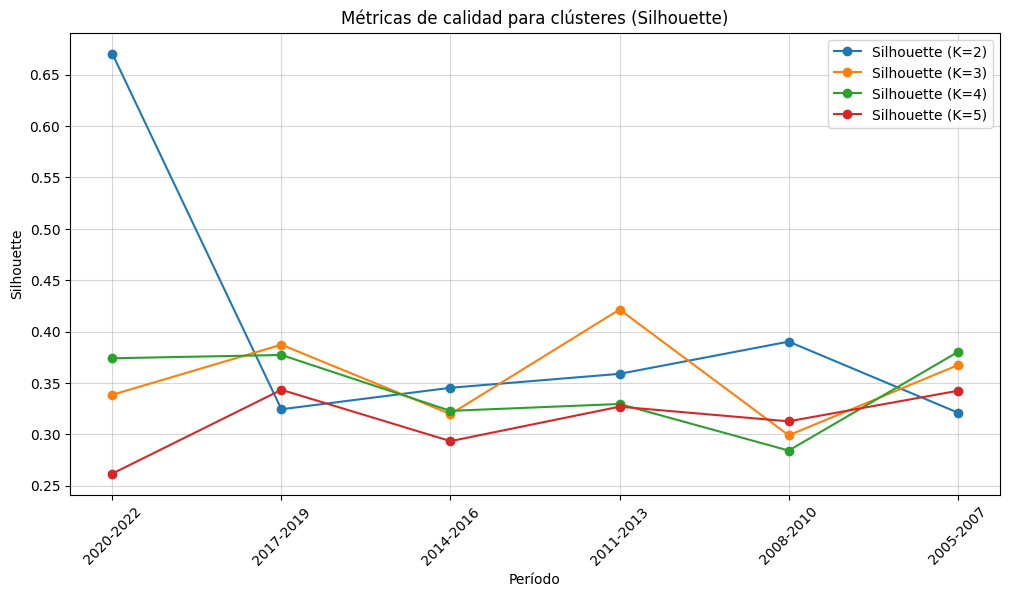

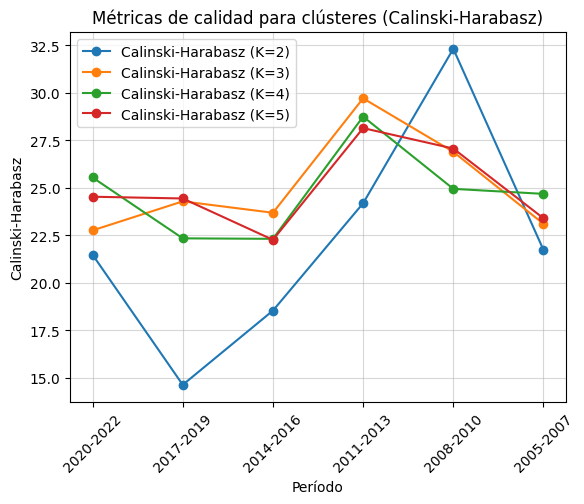

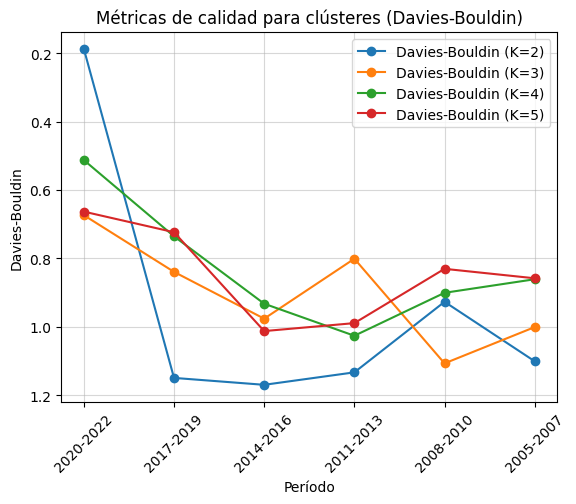

In [65]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Valores de K a evaluar
k_values = [2, 3, 4, 5]

# Lista para almacenar los resultados por período
calidad_clustering = []

# Evaluar la calidad de los clústeres para cada período
for desde, hasta in periodos:
    print(f"Evaluando calidad de clústeres para el período: {desde}-{hasta}")
    
    # Filtrar el DataFrame para el período
    df_periodo = preprocesar_periodo(df, desde, hasta)
    if df_periodo.shape[0] < 3:  # Omitir períodos con muy pocos datos
        print(f"Período {desde}-{hasta} tiene menos de 3 registros, no se evaluará.")
        continue
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(df_periodo[variables])
        
        # Calcular métricas
        silhouette = silhouette_score(df_periodo[variables], labels)
        calinski = calinski_harabasz_score(df_periodo[variables], labels)
        davies = davies_bouldin_score(df_periodo[variables], labels)
        
        # Guardar resultados
        calidad_clustering.append({
            'Periodo': f"{desde}-{hasta}",
            'K': k,
            'Silhouette': silhouette,
            'Calinski-Harabasz': calinski,
            'Davies-Bouldin': davies
        })

# Convertir los resultados a un DataFrame
df_calidad = pd.DataFrame(calidad_clustering)

# Mostrar los resultados
print("Resultados de evaluación de clústeres:")
display(df_calidad)

# Graficar las métricas
plt.figure(figsize=(12, 6))
for metric in ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin']:
    for k in k_values:
        subset = df_calidad[df_calidad['K'] == k]
        plt.plot(subset['Periodo'], subset[metric], label=f"{metric} (K={k})", marker='o')
    plt.title(f'Métricas de calidad para clústeres ({metric})')
    plt.xlabel('Período')
    plt.ylabel(metric)
    if metric == 'Davies-Bouldin':
        plt.gca().invert_yaxis()  # Invertir para que menores valores sean mejores
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(alpha=0.5)
    plt.show()


#### Análisis de resultados de clustering:
* Usando SILHOUETTE como medidor de la calidad de los clusters, para el período 2000 en adelante, usaremos k=3 clusters. Para los anteriores a 2000, usaremos k=2 clusters.

#### Procesamos nuevamente

In [66]:
df.columns

Index(['agno', 'countryname', 'per101', 'per102', 'per103', 'per104', 'per105',
       'per106', 'per107', 'per108', 'per109', 'per110', 'per201', 'per202',
       'per203', 'per204', 'per301', 'per302', 'per303', 'per304', 'per305',
       'per401', 'per402', 'per403', 'per404', 'per405', 'per406', 'per407',
       'per408', 'per409', 'per410', 'per411', 'per412', 'per413', 'per414',
       'per415', 'per416', 'per501', 'per502', 'per503', 'per504', 'per505',
       'per506', 'per507', 'per601', 'per602', 'per603', 'per604', 'per605',
       'per606', 'per607', 'per608', 'per701', 'per702', 'per703', 'per704',
       'per705', 'per706'],
      dtype='object')

In [67]:
# Diccionario para almacenar resultados por período
resultados_temporales = []

for desde, hasta in periodos:
    print(f"\nProcesando período: {desde}-{hasta}")
    
    # Filtrar el DataFrame para el período actual
    df_periodo = preprocesar_periodo(df, desde, hasta)
    if df_periodo.shape[0] < 2:  # Omitir períodos con menos de 2 registros
        print(f"Período {desde}-{hasta} tiene menos de 2 registros, no se procesará.")
        continue
    
    # Decidir el número de clústeres
    if hasta <= 2003:
        num_clusters = 2
    else:
        num_clusters = 3
    print(f"Usando K={num_clusters} para el período {desde}-{hasta}")
    
    # Aplicar K-MEANS
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    df_periodo['Cluster'] = kmeans.fit_predict(df_periodo[variables])
    
    # Guardar los resultados del período
    resultados_temporales.append({
        'Periodo': f"{desde}-{hasta}",
        'K': num_clusters,
        'Clusters': {
            f"Cluster {i}": df_periodo[df_periodo['Cluster'] == i]['countryname'].tolist()
            for i in range(num_clusters)
        }
    })

# Convertir los resultados a un DataFrame
df_resultados = pd.DataFrame(resultados_temporales)

# Mostrar los resultados
print("Resultados del análisis de clústeres:")
display(df_resultados)



Procesando período: 2020-2022

No hay países con más de una elección en el período.
Usando K=3 para el período 2020-2022

Procesando período: 2017-2019
Usando K=3 para el período 2017-2019

Procesando período: 2014-2016

No hay países con más de una elección en el período.
Usando K=3 para el período 2014-2016

Procesando período: 2011-2013
Usando K=3 para el período 2011-2013

Procesando período: 2008-2010
Usando K=3 para el período 2008-2010


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_1834/1439448309.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_periodo['Cluster'] = kmeans.fit_predict(df_periodo[variables])
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_1834/1439448309.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_periodo['Cluster'] = kmeans.fit_predict(df_periodo[variables])



Procesando período: 2005-2007
Usando K=3 para el período 2005-2007
Resultados del análisis de clústeres:


,Periodo,K,Clusters
0,2020-2022,3,"{'Cluster 0': ['Sweden'], 'Cluster 1': ['Armen..."
1,2017-2019,3,"{'Cluster 0': ['Belgium', 'Brazil', 'Bulgaria'..."
2,2014-2016,3,"{'Cluster 0': ['Australia', 'Brazil', 'Croatia..."
3,2011-2013,3,"{'Cluster 0': ['Canada', 'Chile', 'Czech Repub..."
4,2008-2010,3,"{'Cluster 0': ['Australia', 'Austria', 'Bolivi..."
5,2005-2007,3,"{'Cluster 0': ['Argentina', 'Bosnia-Herzegovin..."


In [68]:
df_resultados

,Periodo,K,Clusters
0,2020-2022,3,"{'Cluster 0': ['Sweden'], 'Cluster 1': ['Armen..."
1,2017-2019,3,"{'Cluster 0': ['Belgium', 'Brazil', 'Bulgaria'..."
2,2014-2016,3,"{'Cluster 0': ['Australia', 'Brazil', 'Croatia..."
3,2011-2013,3,"{'Cluster 0': ['Canada', 'Chile', 'Czech Repub..."
4,2008-2010,3,"{'Cluster 0': ['Australia', 'Austria', 'Bolivi..."
5,2005-2007,3,"{'Cluster 0': ['Argentina', 'Bosnia-Herzegovin..."


#### Analicemos cuántas veces dos países coincidieron en un mismo cluster

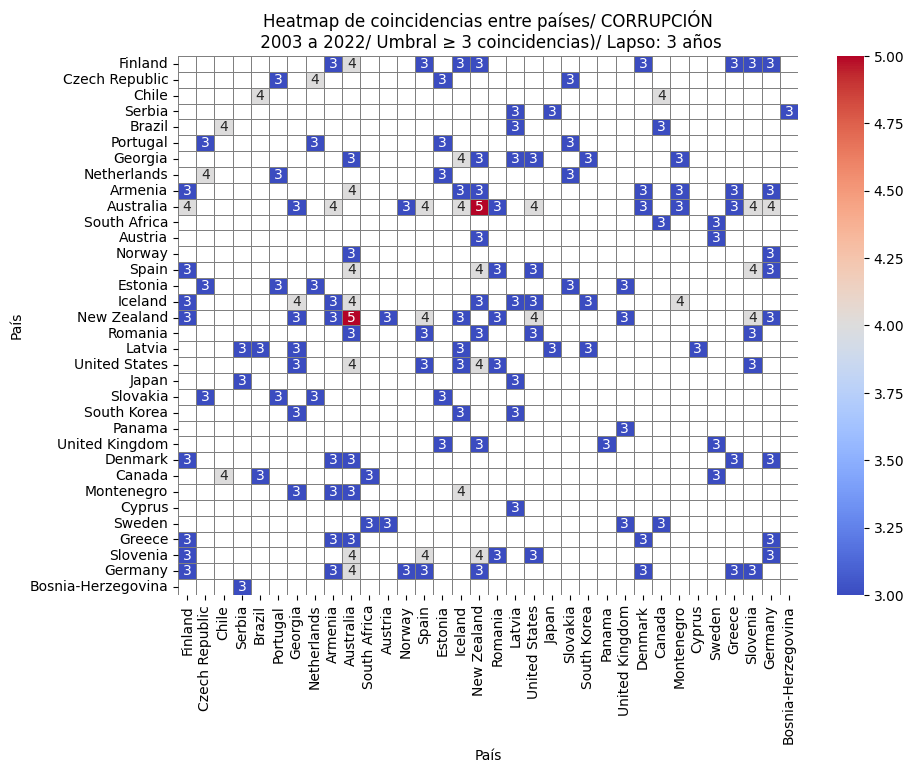

In [69]:
from itertools import combinations
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Definir el umbral de coincidencias
umbral = 3

# Crear una lista de todas las coincidencias
coincidencias = []

for _, row in df_resultados.iterrows():
    clusters = row['Clusters']  # Diccionario de clústeres
    for cluster, countries in clusters.items():
        # Generar todas las combinaciones posibles de países en el clúster
        pairs = list(combinations(countries, 2))
        coincidencias.extend(pairs)

# Contar las coincidencias para cada par de países
df_coincidencias = pd.DataFrame(coincidencias, columns=['País 1', 'País 2'])
df_coincidencias['Coincidencia'] = 1

# Agrupar y contar las coincidencias
coincidence_matrix = df_coincidencias.groupby(['País 1', 'País 2'])['Coincidencia'].sum().unstack(fill_value=0)

# Crear una matriz cuadrada para asegurar simetría
countries = list(set(coincidence_matrix.index).union(coincidence_matrix.columns))
coincidence_matrix = coincidence_matrix.reindex(index=countries, columns=countries, fill_value=0)
coincidence_matrix = coincidence_matrix + coincidence_matrix.T

# Filtrar la matriz según el umbral
coincidence_matrix_filtered = coincidence_matrix[coincidence_matrix >= umbral].dropna(how='all', axis=0).dropna(how='all', axis=1)

# Convertir todos los valores de la matriz filtrada a enteros
coincidence_matrix_filtered = coincidence_matrix_filtered.fillna(0).astype(int)

# Crear una máscara para ocultar celdas con valor 0
mask = coincidence_matrix_filtered == 0

# Visualizar el heatmap con números en las celdas y grilla gris
plt.figure(figsize=(10, 7))
sns.heatmap(
    coincidence_matrix_filtered, 
    annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, linecolor="gray", cbar=True,
    mask=mask  # Aplicar la máscara para ocultar valores 0
)
plt.title(f"Heatmap de coincidencias entre países/ {aspecto_filtro}\n {primer_año} a {último_año}/ Umbral ≥ {umbral} coincidencias)/ Lapso: {lapso} años")
plt.xlabel("País")
plt.ylabel("País")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


#### Veamos si los datos permiten ver patrones de agrupamiento entre países.
* Utilizamos algoritmos de detección de comunidades porque identifican agrupaciones basadas en la densidad de conexiones, lo que refleja patrones inherentes en los datos.

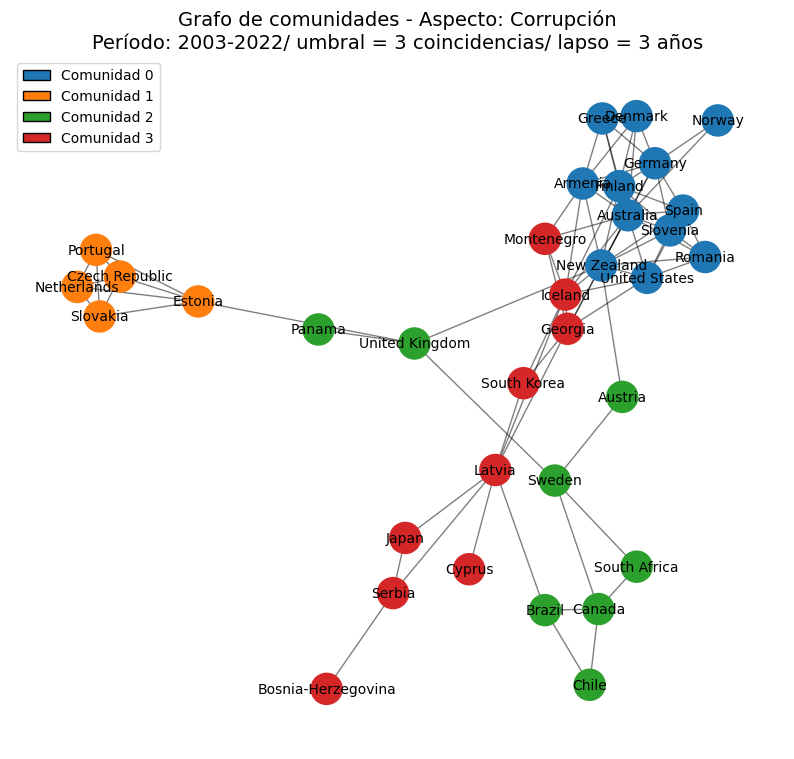

Comunidad 0: Finland, Armenia, Australia, Norway, Spain, New Zealand, Romania, United States, Denmark, Greece, Slovenia, Germany
Comunidad 1: Czech Republic, Portugal, Netherlands, Estonia, Slovakia
Comunidad 2: Chile, Brazil, South Africa, Austria, Panama, United Kingdom, Canada, Sweden
Comunidad 3: Serbia, Georgia, Iceland, Latvia, Japan, South Korea, Montenegro, Cyprus, Bosnia-Herzegovina


In [70]:
import networkx as nx
from community import community_louvain  # Instalar con `pip install python-louvain`
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Datos adicionales para el título
aspecto = "Corrupción"
periodo_inicio = 2003
periodo_fin = 2022

# Convertir la matriz de coincidencias filtrada en un grafo ponderado
G = nx.from_pandas_adjacency(coincidence_matrix_filtered)

# Aplicar el algoritmo de Louvain para detectar comunidades
communities = community_louvain.best_partition(G, weight='weight')

# Ajustar los parámetros del layout para mayor separación
k_value = 0.3  # Aumentar este valor separa más los nodos
iterations = 100  # Más iteraciones para mejorar la distribución
pos = nx.spring_layout(G, k=k_value, iterations=iterations, seed=42)

# Colores para las comunidades
community_colors = {node: f"C{communities[node]}" for node in G.nodes}

# Dibujar el grafo
plt.figure(figsize=(10, 9))
nx.draw_networkx_nodes(G, pos, node_size=500, node_color=list(community_colors.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

# Crear leyenda de comunidades
legend_elements = [
    Patch(facecolor=f"C{community}", edgecolor="black", label=f"Comunidad {community}")
    for community in set(communities.values())
]
plt.legend(handles=legend_elements, loc="upper left", title="")

# Agregar título
plt.title(
    f"Grafo de comunidades - Aspecto: {aspecto}\nPeríodo: {periodo_inicio}-{periodo_fin}/ umbral = {umbral} coincidencias/ lapso = {lapso} años",
    fontsize=14
)
plt.axis("off")
plt.show()

# Mostrar los resultados de las comunidades
from collections import defaultdict
community_groups = defaultdict(list)
for node, community in communities.items():
    community_groups[community].append(node)

for comm, nodes in community_groups.items():
    print(f"Comunidad {comm}: {', '.join(nodes)}")


#### Analicemos las centralidades

Análisis de centralidad:


,País,Degree Centrality,Betweenness Centrality,Eigenvector Centrality
9,Australia,0.424242,0.060161,0.449040
16,New Zealand,0.363636,0.400830,0.373127
0,Finland,0.272727,0.049085,0.292272
32,Germany,0.272727,0.051978,0.274489
15,Iceland,0.272727,0.153908,0.257970
8,Armenia,0.242424,0.047317,0.250958
31,Slovenia,0.212121,0.002841,0.274551
6,Georgia,0.212121,0.157230,0.186295
19,United States,0.212121,0.033306,0.253090
18,Latvia,0.212121,0.302300,0.058946


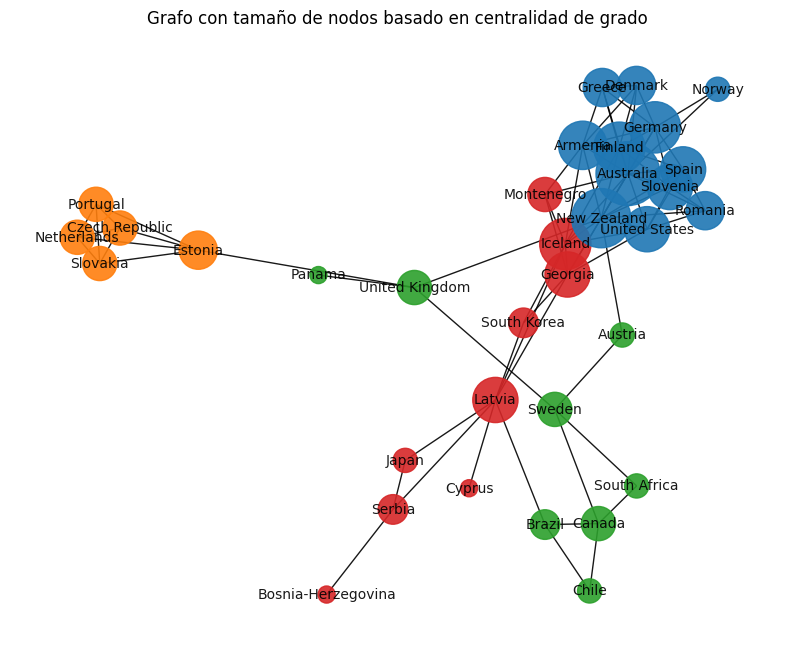

In [71]:
# Calcular las métricas de centralidad
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight')

# Crear un DataFrame para analizar las centralidades
centrality_df = pd.DataFrame({
    'País': list(G.nodes),
    'Degree Centrality': [degree_centrality[node] for node in G.nodes],
    'Betweenness Centrality': [betweenness_centrality[node] for node in G.nodes],
    'Eigenvector Centrality': [eigenvector_centrality[node] for node in G.nodes]
}).sort_values(by='Degree Centrality', ascending=False)

# Mostrar los países clave según centralidades
print("Análisis de centralidad:")
display(centrality_df)

# Visualizar la centralidad de grado en el grafo
plt.figure(figsize=(10, 8))
node_sizes = [5000 * degree_centrality[node] for node in G.nodes]

nx.draw_networkx(
    G, pos, with_labels=True, node_size=node_sizes, 
    node_color=list(community_colors.values()), alpha=0.9, font_size=10
)
plt.title("Grafo con tamaño de nodos basado en centralidad de grado")
plt.axis("off")
plt.show()


#### Sustentemos el análisis observando los datos de las variables consideradas, en cada comunidad.

Promedios de las variables por comunidad y del dataset:


,per603,per604,per605,per304
Comunidad,,,,
0,1.520047,0.133878,2.409427,0.612475
1,2.001001,0.260074,4.777077,0.842370
2,0.947457,0.129773,3.415475,1.135820
3,0.910009,0.041275,1.960428,2.650676
Dataset,1.532251,0.195463,2.742213,1.324202


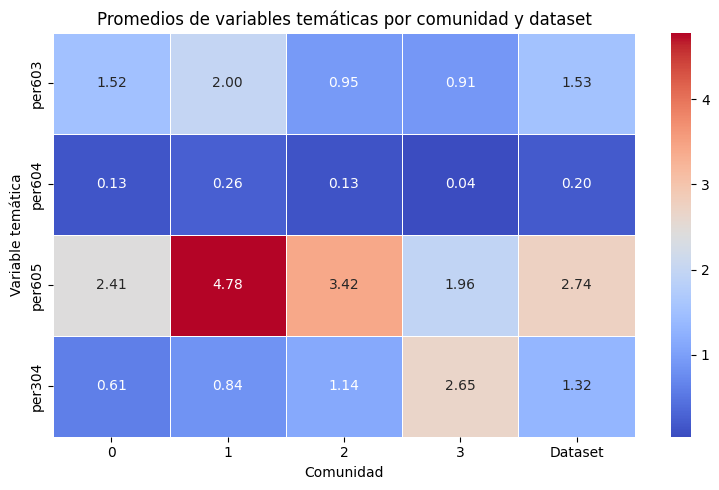

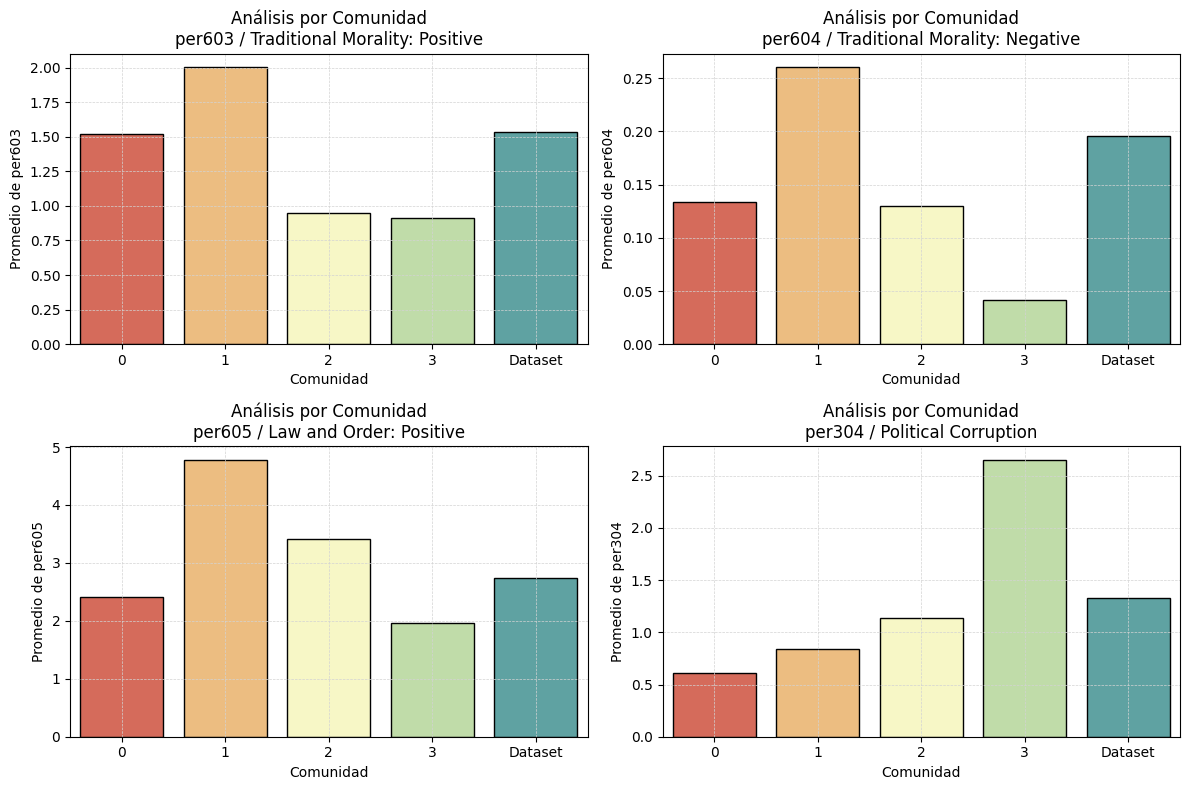


Países agrupados por comunidad (umbral=3 coincidencias):
Comunidad 0:
Armenia, Australia, Denmark, Finland, Germany, Greece, New Zealand, Norway, Romania, Slovenia, Spain, United States
Comunidad 1:
Czech Republic, Estonia, Netherlands, Portugal, Slovakia
Comunidad 2:
Austria, Brazil, Canada, Chile, Panama, South Africa, Sweden, United Kingdom
Comunidad 3:
Bosnia-Herzegovina, Cyprus, Georgia, Iceland, Japan, Latvia, Montenegro, Serbia, South Korea


,Comunidad,Países
0,0,"Armenia, Australia, Denmark, Finland, Germany,..."
1,1,"Czech Republic, Estonia, Netherlands, Portugal..."
2,2,"Austria, Brazil, Canada, Chile, Panama, South ..."
3,3,"Bosnia-Herzegovina, Cyprus, Georgia, Iceland, ..."


In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# Crear un diccionario a partir de 'df_AD' para mapear 'Variable_per' a 'Detalle_Dominio'
variable_details = df_AD.set_index('Variable_per')['Detalle_Dominio'].to_dict()

# Crear un DataFrame con países y comunidades, basado en los nodos del grafo
community_data = pd.DataFrame({
    'countryname': list(communities.keys()),  # Países en el grafo
    'Comunidad': list(communities.values())
}).merge(df, on='countryname', how='inner')  # Asociar con datos de `df`

# Seleccionar las variables relevantes
corrupcion_vars = ['per603', 'per604', 'per605', 'per304']  # Variables de corrupción
all_vars = corrupcion_vars  # Puedes incluir más variables aquí

# Calcular promedios por comunidad basado solo en países del grafo
summary_by_community = community_data.groupby('Comunidad')[all_vars].mean()

# Calcular el promedio global del dataset para las variables en análisis
dataset_means = df[all_vars].mean()

# Añadir la fila de promedios del dataset al dataframe
summary_by_community.loc['Dataset'] = dataset_means

# Mostrar los promedios por comunidad con la fila del dataset
print("Promedios de las variables por comunidad y del dataset:")
display(summary_by_community)

# Visualizar con un heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(
    summary_by_community.T, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5
)
plt.title("Promedios de variables temáticas por comunidad y dataset")
plt.xlabel("Comunidad")
plt.ylabel("Variable temática")
plt.tight_layout()
plt.show()

# Comparar comunidades para variables específicas (de a 2 gráficos lado a lado)
num_vars = len(corrupcion_vars)
fig, axes = plt.subplots(nrows=(num_vars + 1) // 2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

for i, var in enumerate(corrupcion_vars):
    # Obtener la descripción de la variable
    description = variable_details.get(var, "Descripción no disponible")
    sns.barplot(
        ax=axes[i], 
        x=summary_by_community.index, 
        y=summary_by_community[var], 
        palette="Spectral", 
        edgecolor="black"
    )
    axes[i].set_title(f"Análisis por Comunidad\n{var} / {description}")
    axes[i].set_xlabel("Comunidad")
    axes[i].set_ylabel(f"Promedio de {var}")
    axes[i].grid(color="lightgray", linestyle="--", linewidth=0.5)

# Ocultar gráficos extra si las variables no llenan todas las celdas
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

# Crear un diccionario para agrupar países por comunidad
community_groups = defaultdict(list)
for country, community in communities.items():
    community_groups[community].append(country)

# Mostrar los países de cada comunidad
print(f"\nPaíses agrupados por comunidad (umbral={umbral} coincidencias):")
sorted_communities = sorted(community_groups.items())
for community, countries in sorted_communities:
    print(f"Comunidad {community}:")
    print(", ".join(sorted(countries)))

# Crear un DataFrame con las comunidades y sus países
community_df = pd.DataFrame([
    {"Comunidad": community, "Países": ", ".join(sorted(countries))}
    for community, countries in sorted_communities
])
display(community_df)
